# Calculation of the TOV for the mixed EOS: NSM

## Alexandra Semposki

### Date: 21 October 2024

This notebook calculates the TOV equations for given data from the EOS from Bayesian model mixing. It then compares the 20n0 and 40n0 cutoff cases, and plots them in comparison to the NICER and LIGO data in the M-R posterior.

In [1]:
# import packages
%load_ext autoreload
%autoreload 2

import corner
import pickle
import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [2]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

In [3]:
# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
display(df_insens)

df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')
display(df_maxmass)

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.543236,1.205749,97.068200,248.541197,10.730811,9.358211
1,1.482590,1.253115,19.677667,280.480973,8.186003,9.833989
2,1.541613,1.206940,31.524739,235.511540,9.149591,9.373914
3,1.562878,1.191476,49.572338,409.681755,9.951128,10.102846
4,1.656298,1.128266,27.441288,246.930128,9.602853,9.395534
...,...,...,...,...,...,...
2916,1.508332,1.232504,91.421409,229.584025,10.730333,9.901073
2917,1.602577,1.163587,59.820623,266.473512,10.058355,9.314710
2918,1.561251,1.192543,12.951990,234.310549,8.475787,9.328835
2919,1.476021,1.258401,126.699863,346.595638,10.741590,10.844589


,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.637296,1.140765,66.373870,723.523060,10.887391,11.097352
1,1.612825,1.156845,191.207304,1335.339873,12.402063,12.349246
2,1.563015,1.191614,200.526550,1156.272842,12.285450,12.501216
3,1.625307,1.148567,134.833116,1439.597356,12.141489,12.627265
4,1.625909,1.148243,177.099466,1428.281697,12.399686,12.426146
...,...,...,...,...,...,...
2391,1.456157,1.275411,271.138172,593.167994,11.771023,11.732749
2392,1.363036,1.361102,275.144868,277.559025,11.146219,11.146212
2393,1.547311,1.202998,308.382837,1352.958123,12.800400,12.770993
2394,1.379074,1.345569,253.244553,293.279550,11.077769,11.070750


In [4]:
# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

In [5]:
# load results from the NSM notebooks for pressure, energy density, speed of sound
with open('pres_data_20n0.pkl', 'rb') as fp:
    pressure_dict = pickle.load(fp)  # automatically in order of saving
    edens_dict = pickle.load(fp)
    cs2_dict = pickle.load(fp)
    
with open('pres_data_mean_40n0.pkl', 'rb') as fp:
    pressure_dict_mean_40 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_40 = pickle.load(fp)
    cs2_dict_mean_40 = pickle.load(fp)
    
with open('pres_data_mean_20n0.pkl', 'rb') as fp:
    pressure_dict_mean_20 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_20 = pickle.load(fp)
    cs2_dict_mean_20 = pickle.load(fp)

In [6]:
# check the number of things
print(pressure_dict_mean_20['mean'].shape)
print(pressure_dict_mean_20['dens'].shape)

(899,)
(899,)


In [7]:
# number of samples
#samples = len(pressure_dict['samples'].T)

# TOV data creation (streamlined)
# tov_dict = tov_data(edens_dict, pressure_dict, save=True, \
#                     filepath='../data/TOV_data/eos_stationary_20n0.npz')

# run the TOV solver over each sample
# mass_data = np.zeros([50,samples])
# radius_data = np.zeros([50,samples])
# pressure_data = np.zeros([50,samples])

# call the solver once, send all data directly
#tov = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_20n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
#radius_data, pressure_data, mass_data = tov.tov_routine(verbose=False, write_to_file=False)

In [8]:
# MEAN CALCULATIONS
density_test = np.linspace(0.05, 16.4, 900)[:-1]

# TOV data creation (streamlined)
low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# now work with the mean and std of pressure, energy density (envelope calculation)
edens_lower = edens_dict_mean_20['lower']
edens_higher = edens_dict_mean_20['upper']
edens_mean = edens_dict_mean_20['mean']
pres_lower = pressure_dict_mean_20['mean'] - pressure_dict_mean_20['std_dev']
pres_higher = pressure_dict_mean_20['mean'] + pressure_dict_mean_20['std_dev']
gp_mean = pressure_dict_mean_20['mean']
gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# concatenate into "samples"
edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# save data in dat file backwards
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_envelope[tov_index:]
gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T 
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
np.savez('../data/TOV_data/eos_stationary_mean_20n0.npz', density=dens_tov, \
         edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# run the TOV solver over each sample
mass_data_mean_20 = np.zeros([50])
radius_data_mean_20 = np.zeros([50])
pressure_data_mean_20 = np.zeros([50])

# call the solver once, send all data directly
tov_mean_20 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_20n0.npz', tidal=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_mean_20, pressure_data_mean_20, mass_data_mean_20 = \
tov_mean_20.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  7.8348240992000004 Maximum mass:  1.2981791157497946 Central pressure:  867.6756497154504
Radius:  10.153274741599999 Maximum mass:  1.6798775613127093 Central pressure:  466.5364423805275
Radius:  12.3511123448 Maximum mass:  2.182358768044537 Central pressure:  342.0973067434033


In [9]:
# look at the central densities
cdens_mean_20 = tov_mean_20.central_dens()

print('Central density envelope: ', cdens_mean_20, 'fm^-3')
print('Central densities in n0: ', cdens_mean_20/n0)

Central density envelope:  [2.11205855 1.38007237 1.02967972] fm^-3
Central densities in n0:  [12.87840579  8.41507544  6.27853489]


In [10]:
# MEAN CALCULATIONS

# now work with the mean and std of pressure, energy density (envelope calculation)
edens_lower = edens_dict_mean_40['lower']
edens_higher = edens_dict_mean_40['upper']
edens_mean = edens_dict_mean_40['mean']
pres_lower = pressure_dict_mean_40['mean'] - pressure_dict_mean_40['std_dev']
pres_higher = pressure_dict_mean_40['mean'] + pressure_dict_mean_40['std_dev']
gp_mean = pressure_dict_mean_40['mean']
gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# concatenate into "samples"
edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# save data in dat file backwards
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_envelope[tov_index:]
gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T 
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
np.savez('../data/TOV_data/eos_stationary_mean_40n0.npz', density=dens_tov, \
         edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# run the TOV solver over each sample
mass_data_mean_40 = np.zeros([50])
radius_data_mean_40 = np.zeros([50])
pressure_data_mean_40 = np.zeros([50])

# call the solver once, send all data directly
tov_mean_40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_40n0.npz', tidal=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_mean_40, pressure_data_mean_40, mass_data_mean_40 = \
tov_mean_40.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  6.6152922584 Maximum mass:  1.0135545837690259 Central pressure:  1183.2958131473647
Radius:  9.2955820184 Maximum mass:  1.3934106823412422 Central pressure:  466.5364423805275
Radius:  11.533623967999999 Maximum mass:  1.913242337041036 Central pressure:  342.0973067434033


In [11]:
# look at the central densities
cdens_mean_40 = tov_mean_40.central_dens()

print('Central density envelope: ', cdens_mean_40, 'fm^-3')
print('Central densities in n0: ', cdens_mean_40/n0)

Central density envelope:  [2.84896715 1.55464071 1.12466638] fm^-3
Central densities in n0:  [17.37175092  9.47951654  6.85772183]


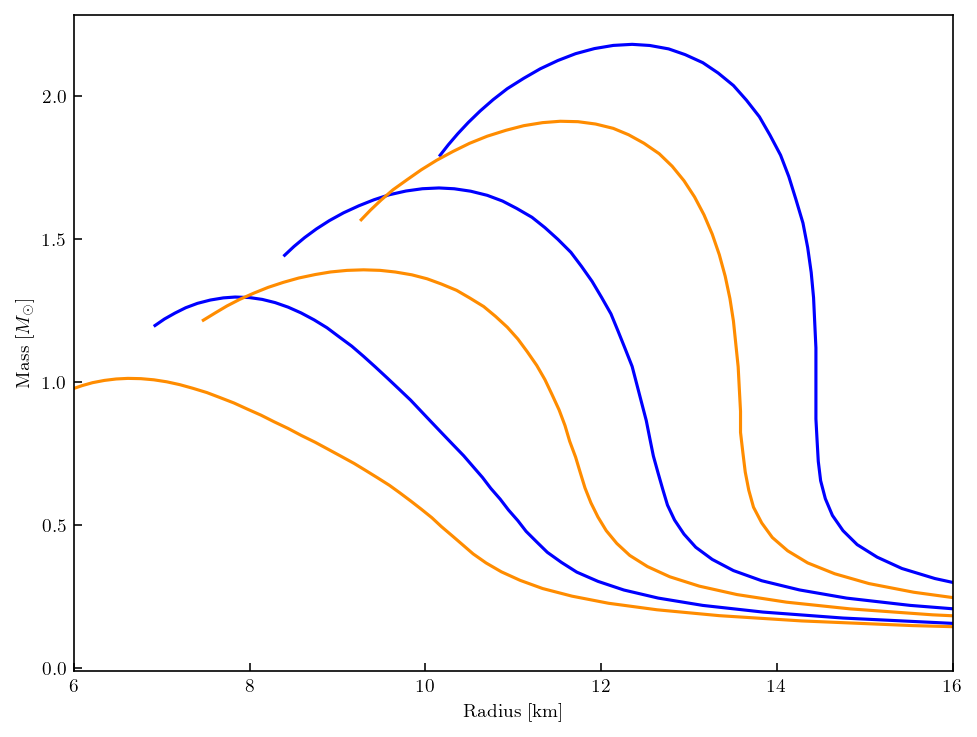

In [12]:
plt.plot(radius_data_mean_20, mass_data_mean_20, color='blue')
plt.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange')
plt.ylabel('Mass [$M_{\odot}$]')
plt.xlabel('Radius [km]')
plt.xlim(6.0, 16.0)
plt.show()

In [14]:
# run the maximum mass and radius for the arrays to save
m_rad, m_pres, m_mass = tov_mean_20.max_arrays()

# save the radii, pressures, and masses
#np.savez('rpm_results_stationary_20n0.npz', radius=radius_data, central_pressure=pressure_data, mass=mass_data, max_radius=m_rad, max_mass=m_mass)

In [15]:
# load the 40n0 results
# with open('pres_data_40n0.pkl', 'rb') as fp:
#     pressure_dict_40n0 = pickle.load(fp)  # automatically in order of saving
#     edens_dict_40n0 = pickle.load(fp)
#     cs2_dict_40n0 = pickle.load(fp)

In [16]:
# number of samples
# samples_40n0 = len(pressure_dict_40n0['samples'].T)

# # TOV data creation (streamlined)
# tov_dict_40n0 = tov_data(edens_dict_40n0, pressure_dict_40n0, save=True, \
#                     filepath='../data/TOV_data/eos_stationary_40n0.npz')

# # run the TOV solver over each sample
# mass_data_40n0 = np.zeros([50,samples_40n0])
# radius_data_40n0 = np.zeros([50,samples_40n0])
# pressure_data_40n0 = np.zeros([50,samples_40n0])

# # call the solver once, send all data directly
# tov40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_40n0.npz')

# # call routine once (should do its thing...check why central pressures are the same for different ones)
# radius_data_40n0, pressure_data_40n0, mass_data_40n0 = tov40.tov_routine(verbose=False, write_to_file=False)

In [17]:
# run the maximum mass and radius for the arrays to save
m_rad_40n0, m_pres_40n0, m_mass_40n0 = tov_mean_40.max_arrays()

# save the radii, pressures, and masses
# np.savez('rpm_results_stationary_40n0.npz', radius=radius_data_40n0, central_pressure=pressure_data_40n0, \
#          mass=mass_data_40n0, max_radius=m_rad_40n0, max_mass=m_mass_40n0)

In [18]:
# load the data for the overlay plot
stationary_20 = np.load('rpm_results_stationary_20n0.npz')
stationary_40 = np.load('rpm_results_stationary_40n0.npz')

# separate it all out
radius20n0 = stationary_20['radius']
cpres20n0 = stationary_20['central_pressure']
mass20n0 = stationary_20['mass']
maxrad20n0 = stationary_20['max_radius']
maxmass20n0 = stationary_20['max_mass']

radius40n0 = stationary_40['radius']
cpres40n0 = stationary_40['central_pressure']
mass40n0 = stationary_40['mass']
maxrad40n0 = stationary_40['max_radius']
maxmass40n0 = stationary_40['max_mass']

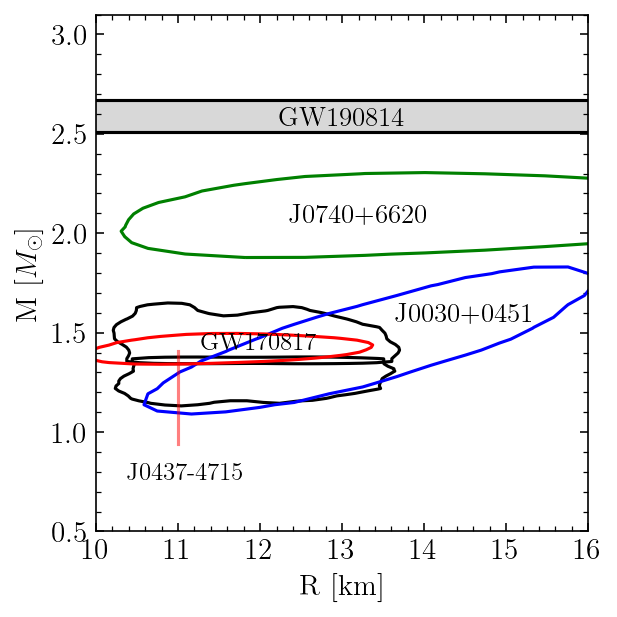

In [19]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='green', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='blue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
ax.text(13.2, 2.15, r'J0740+6620', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'J0030+0451', ha='center', va='top', fontsize=13)
# GW 190814
fake_linspace = np.linspace(10.0, 16.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.3, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(13.0, 2.635, r'GW190814', ha='center', va='top', fontsize=13)
ax.set_ylim(0.5,3.1)
ax.set_xlim(10.0,16.0)
# ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(right=True, top=True, which='both', labelsize=14)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r'R [km]', fontsize=14)
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=14)
ax.text(12.0, 1.5, r'GW170817', ha='center', va='top', fontsize=12)
ax.axvline(x=11.0, ymin=0.17, ymax=0.35, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'J0437-4715', ha='center', va='top', fontsize=12)
plt.show()
plt.show()

(0.0, 3.0)

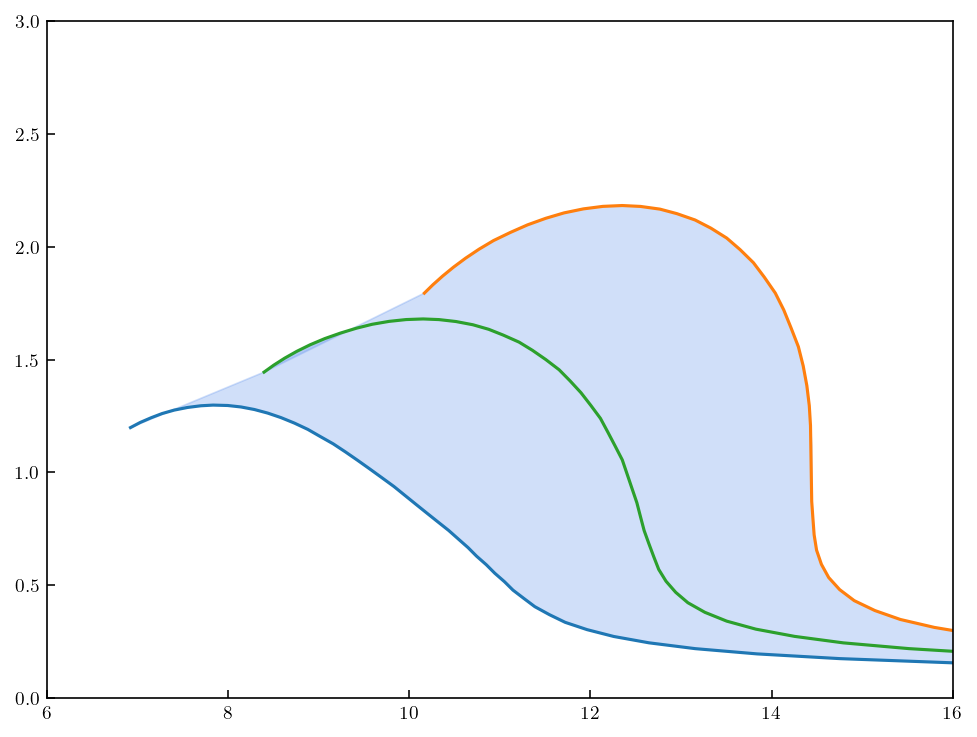

In [125]:
# interpolate the M-R curves and see if things happen
# reverse radius array
radius_copy = radius_data_mean_20[::-1]

mr_interp_20_mean = interp1d(radius_data_mean_20[:,1], mass_data_mean_20[:,1], \
                             kind='cubic', fill_value='extrapolate')
mr_interp_20_lower = interp1d(radius_data_mean_20[:,0], mass_data_mean_20[:,0], \
                             kind='cubic', fill_value='extrapolate')
mr_interp_20_upper = interp1d(radius_data_mean_20[:,2], mass_data_mean_20[:,2], \
                             kind='linear', fill_value='extrapolate')

# interpolate the M-R upper curve at the lower bound (this makes no sense right now)
index_mean_upper = np.where([radius_data_mean_20[-1,2] >= radius_data_mean_20[i,1] \
                for i in range(len(radius_data_mean_20))])[0][-1]

# radius of mean 1 and then interpolate from that point
interp_mean_at_higher_2 = mr_interp_20_mean(radius_data_mean_20[:index_mean_upper+1, 2])

# stitch these together and see
radius_full = radius_data_mean_20[:index_mean_upper+1, 2]
mass_full = interp_mean_at_higher_2

from matplotlib.patches import Polygon

# Define vertices for the region
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.3)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.3)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

# plt.plot(radius_data_mean_20[index_mean_upper:, 2], interp_mean_at_higher)
# plt.plot(radius_data_mean_20[:index_mean_upper+1, 2], interp_mean_at_higher_2)
#plt.fill_between(radius_full, mass_full, mr_interp_20_upper(radius_full))
plt.plot(radius_data_mean_20[:,0], mr_interp_20_lower(radius_data_mean_20[:,0]))
plt.plot(radius_data_mean_20[:,2], mr_interp_20_upper(radius_data_mean_20[:,2]))
plt.plot(radius_data_mean_20[:,1], mr_interp_20_mean(radius_data_mean_20[:,1]))
plt.xlim(6.0, 16.0)
plt.ylim(0.0, 3.0)

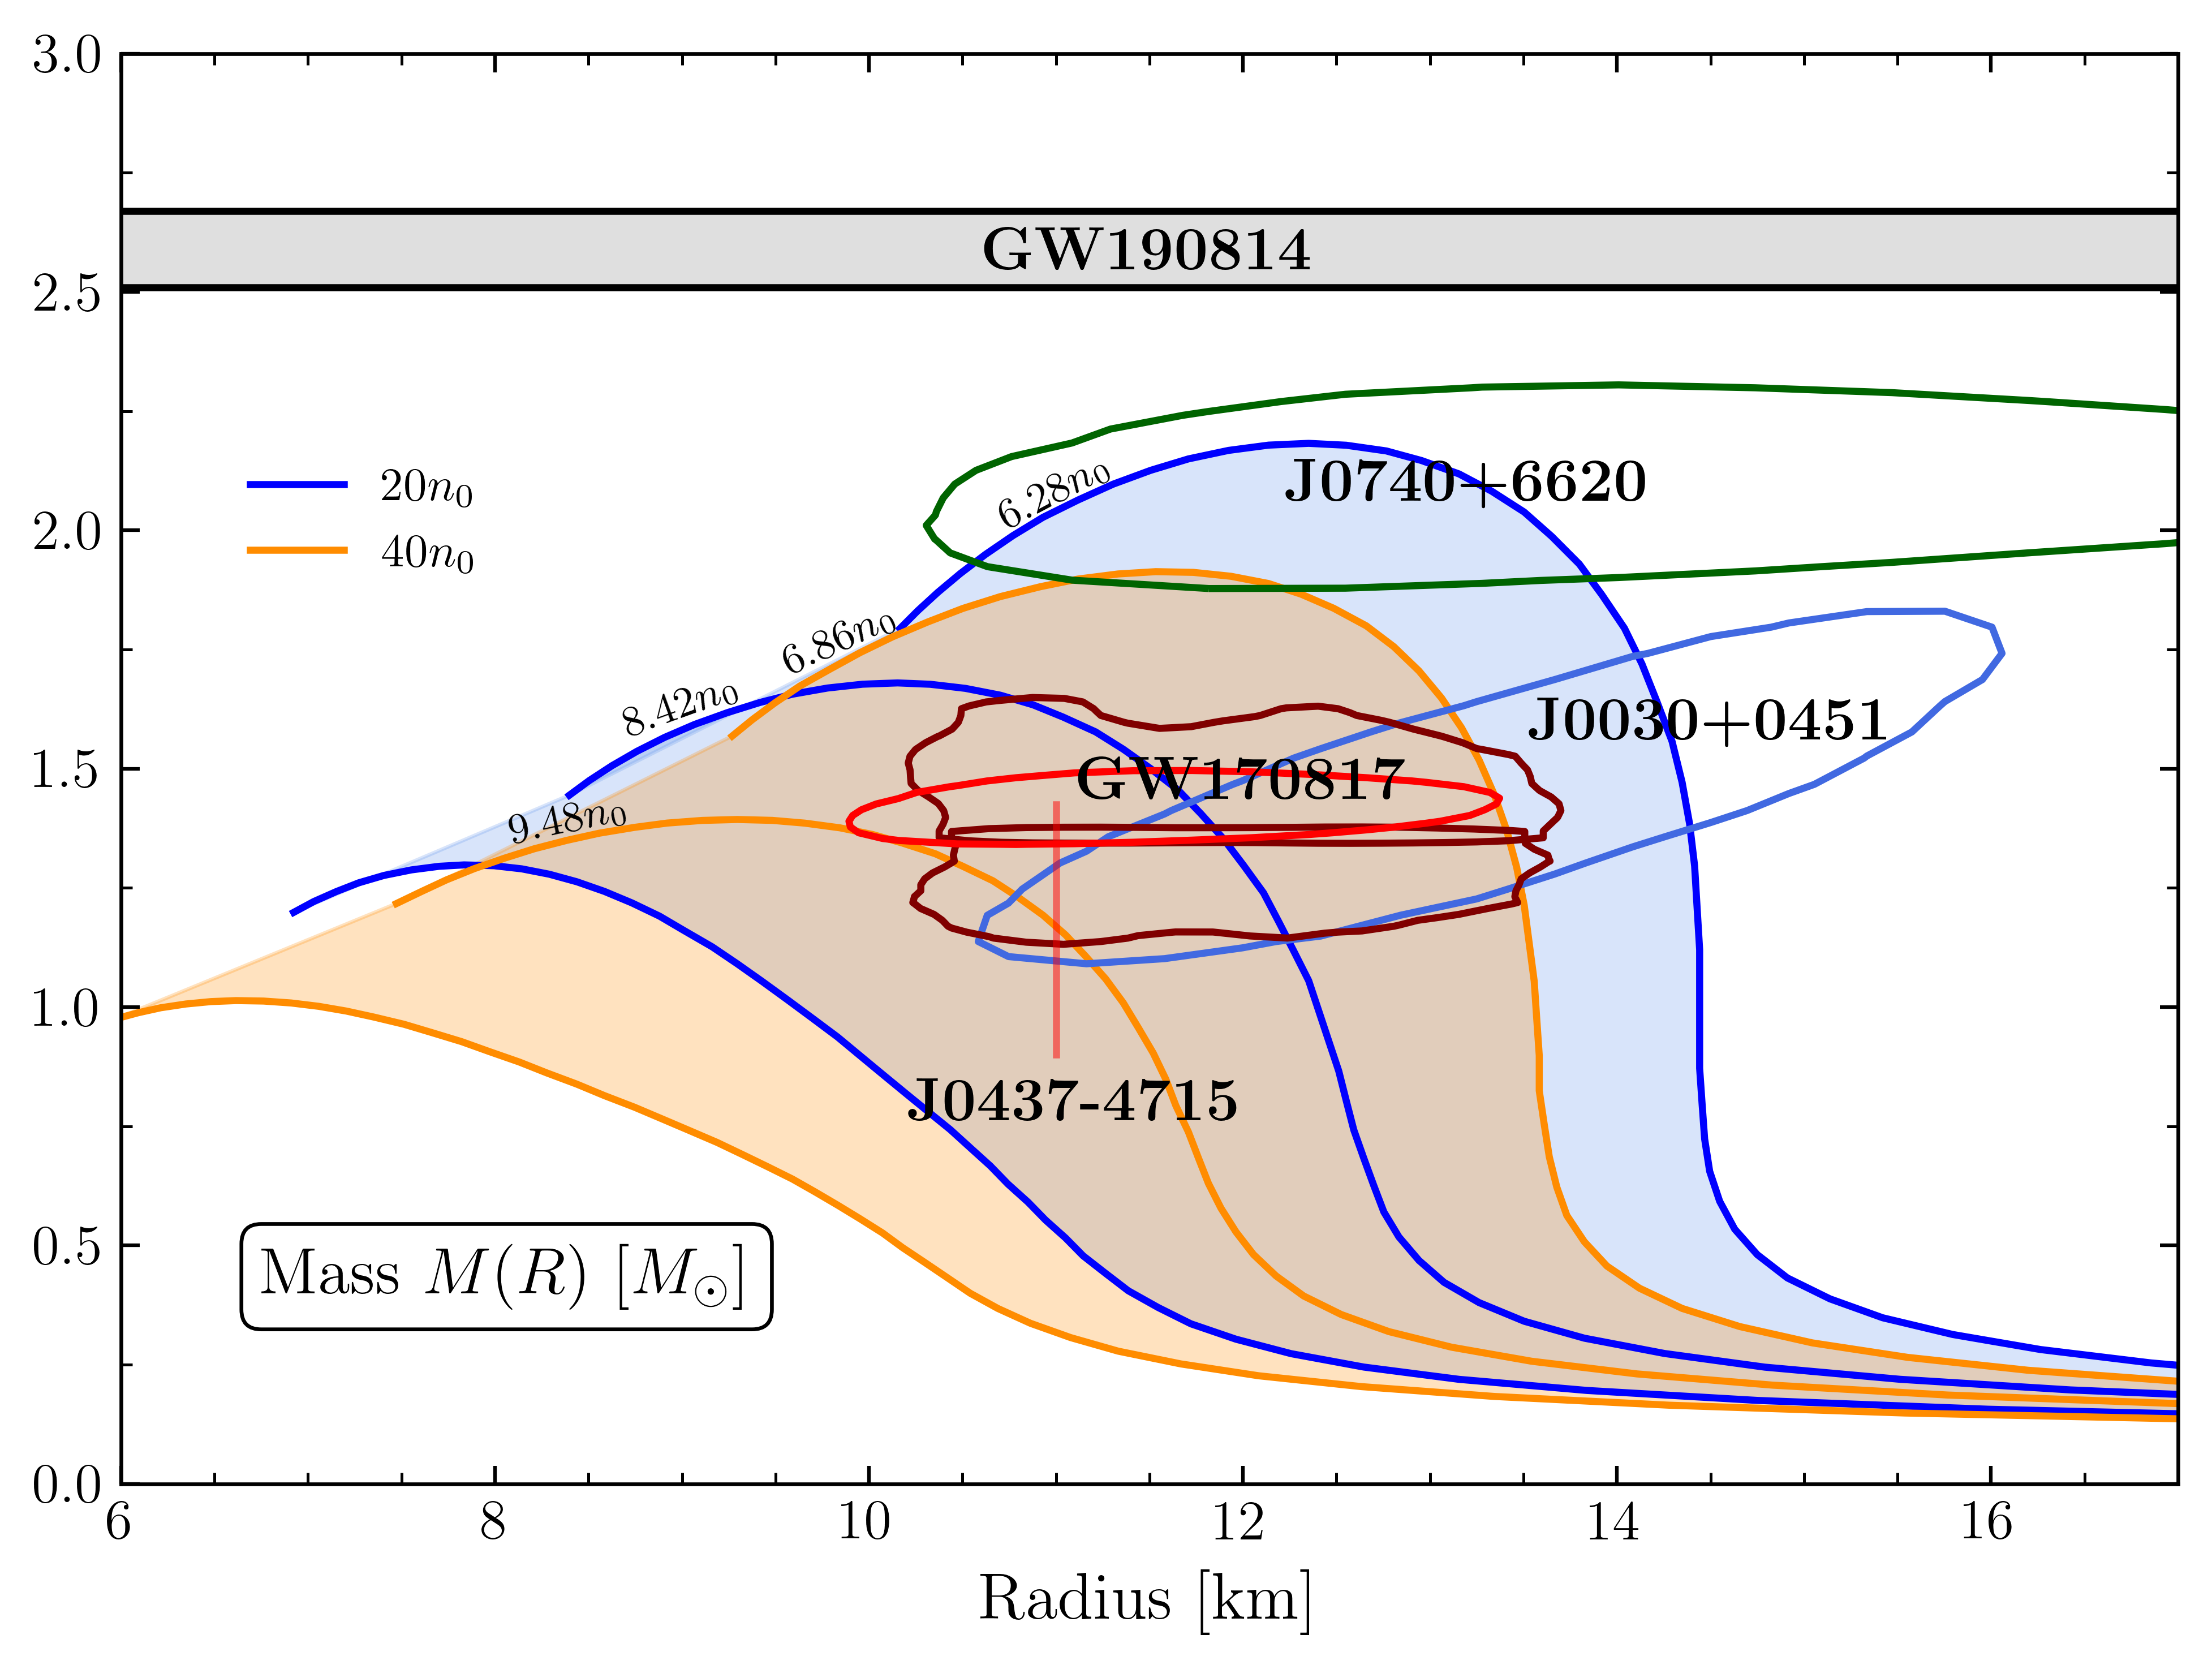

In [171]:
import matplotlib.patches as mpatches

# # define royal purple for contours
#royal_purple = '#9B30FF'

# plot the results including the samples and the overall mean, std_dev
fig, ax = plt.subplots(1,1, dpi=600)

# means
ax.plot(radius_data_mean_20, mass_data_mean_20, color='blue', label=r'$20n_{0}$')
ax.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange', label=r'$40n_{0}$')

# 20n0
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

# 40n0
vertices40 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,1], mass_data_mean_40[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,2]), reversed(mass_data_mean_40[:,2]))]
vertices402 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,0], mass_data_mean_40[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,1]), reversed(mass_data_mean_40[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

polygon40 = Polygon(vertices40, closed=True, color="darkorange", alpha=0.25)
polygon402 = Polygon(vertices402, closed=True, color="darkorange", alpha=0.25)
plt.gca().add_patch(polygon40)
plt.gca().add_patch(polygon402)

handles, labels = plt.gca().get_legend_handles_labels()

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=10, frameon=False, bbox_to_anchor=[0.2, 0.75])

# NICER and LIGO contours
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
    
# labels for LIGO and NICER data
ax.text(13.2, 2.15, r'$\textbf{J0740+6620}$', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', ha='center', va='top', fontsize=13)

# GW 190814
fake_linspace = np.linspace(6.0, 17.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.25, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(11.5, 2.635, r'$\textbf{GW190814}$', ha='center', va='top', fontsize=13)
ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=13, zorder=10)
ax.axvline(x=11.0, ymin=0.30, ymax=0.475, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=13)

# adding labels for central densities of the top 2 curves
ax.text(8.4, 1.39, r'{:.2f}$n_0$'.format(cdens_mean_40[1]/n0), rotation=12, va='center', ha='center')
ax.text(9.85, 1.77, r'{:.2f}$n_0$'.format(cdens_mean_40[2]/n0), rotation=25, va='center', ha='center')

ax.text(9.0, 1.63, r'{:.2f}$n_0$'.format(cdens_mean_20[1]/n0), rotation=20, va='center', ha='center')
ax.text(11.0, 2.08, r'{:.2f}$n_0$'.format(cdens_mean_20[2]/n0), rotation=28, va='center', ha='center')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=12, right=True, top=True)
ax.tick_params(axis='both', which='minor', labelsize=12, right=True, top=True)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,3.0)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.40, r'Mass $M(R)$ $[M_\odot]$', fontsize=14, bbox=dict(facecolor='w', boxstyle='round'))
#fig.savefig('basic_overlay_mr_curves.png')
plt.show()

# extract the contour, see if we can use it for the selection of curves!
# contour_collections = ax.collections
# contours = contour_collections[:2]

# vertices = []
# for contour in contours:
#     for path in contour.get_paths():
#         vertices.append(path.vertices)
        
# vertices_first = np.asarray(vertices)[0]

In [132]:
# write central densities
print(cdens_mean_20/n0)
print(cdens_mean_40/n0)

[12.87840579  8.41507544  6.27853489]
[17.37175092  9.47951654  6.85772183]
